(675, 3)


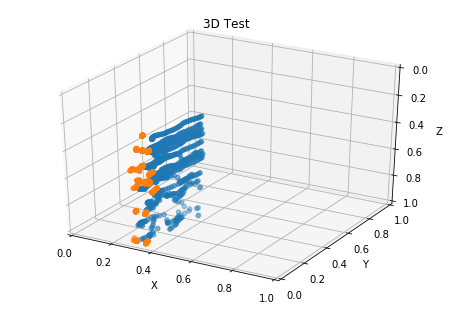

(45, 90)
[ 0.70597    0.42805    0.219264   0.71528    0.52981    0.2127616  0.72547
  0.63455    0.2064     0.73125    0.50462    0.199168   0.71242    0.71597
  0.187584   0.67555    0.86741    0.1871104  0.6993     0.55499    0.2263552
  0.69712    0.70962    0.2284544  0.68304    0.84954    0.2223232  0.75203
  0.72196    0.1914624  0.71558    0.93778    0.1924864  0.71459    1.1505
  0.1923968  0.72522    0.75574    0.2089216  0.6942     0.96949    0.2165504
  0.66437    1.1751     0.2238336]
dist_from_joints_to_joint
[ 0.22999567  0.11810187  0.          0.1085248   0.06533779  0.21390673
  0.13198195  0.05543207  0.16439982  0.12641066  0.36105712  0.59046105
  0.1112683   0.33589854  0.552354  ]
dist_from_video_to_joint
(45, 15)
pos_from_joints_to_joint
[ 0.00413   -0.22986    0.0067328  0.0023    -0.11803    0.0034176  0.         0.
  0.         0.01805   -0.10533    0.0189056  0.01475    0.05806    0.0260864
  0.04243    0.20847    0.022272  -0.01345   -0.13074   -0.0120576 -

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
# Attaching 3D axis to the figure
import os

#preprocess
def get_video(src_file):
    video = src_file.read().splitlines()
    # video[:,3,6,9...]
    for i in range(len(video)):
        frame = video[i].split(',')[1:]#escape the first number
        frame = [float(j) for j in frame] # turn them into float
        video[i] = frame
    
    video = np.array(video)
    for i in range(video.shape[1]/3):
        video[:,i*3+2] = video[:,i*3+2]/7.8125
    
    
    return video

def get_subject_video(video,subject):
    return video[:,subject*45:subject*45+45]


def get_act_subject(video):
    subject_dist = list()
    for subject in [0,1]:
        total_dist = 0
        s_video = get_subject_video(video,subject)
        for i in range(1,len(video)):
            # print i
            total_dist = total_dist + vect_length(s_video[i,:]-s_video[i-1,:])
        subject_dist.append(total_dist)
    if subject_dist[0]>subject_dist[1]:
        act_subject = 0
    else:
        act_subject = 1
    return act_subject


def divide_video(video):
    act_subject = get_act_subject(video)
    react_subject = 1-act_subject
    act_video = get_subject_video(video, act_subject)
    react_video = get_subject_video(video, react_subject)
    return act_video, react_video

def vect_length(vect):
    return np.dot(vect,vect)**0.5

def dist_from_joints_to_joint(joints,joint):
    # assume joints is (x1,y1,z1,x2,y2,z2,...)
    joints_num = len(joints)/3
    
    dist_list = np.zeros(joints_num)
    for i in range(joints_num):
        vect = get_joint(joints,i)-joint
        dist_list[i] = vect_length(vect)
    return dist_list

def pos_from_joints_to_joint(joints,joint):
    temp = np.array([])
    for i in range(len(joints)/3):
        temp = np.append(temp,joint)
    return joints-temp

def dist_from_video_to_joint(video,joint):
    dist_mat = np.array([])
    for i in range(len(video)):
        dist_list = dist_from_joints_to_joint(video[i,:], joint)
        dist_mat = np.vstack((dist_mat, dist_list)) if dist_mat.size else dist_list
    return dist_mat

def get_joint(video,joint):
    if len(video.shape)==1: #only a frame
        return video[3*joint:3*joint+3]
    else:
        return video[:, 3*joint:3*joint+3]

    
# visualization learned intense
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
# Attaching 3D axis to the figure
# main function
def draw_vector(ax,s,e):
    subtract = s-e
    vlength = np.dot(subtract,subtract)**0.5
    print s, e, s-e
    print s[2],s[0],s[1]

    ax.quiver(s[2],s[0],s[1],e[2],e[0],e[1],length = vlength)
    #ax.quiver(start_point[0],start_point[1],start_point[2],end_point[0],end_point[1],end_point[2],length = vlength)

def canvas():
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    # Setting the axes properties
    ax.set_xlim3d([0.0, 1.0])
    ax.set_xlabel('X')
    ax.set_ylim3d([0.0, 1.0])
    ax.set_ylabel('Y')
    ax.set_zlim3d([1.0, 0.0])
    ax.set_zlabel('Z')
    ax.set_title('3D Test')
    return fig,ax
    
def draw_points(ax,points):
    ax.scatter(points[:,2],points[:,0],points[:,1])

    
fn = 'sbu_cleaned/01/s01s02001.txt'
with open(fn,'r') as src_file:
    video = get_video(src_file)
    act_video, react_video = divide_video(video)        
    fig, ax = canvas()
    
    #ax.scatter(j1z,j1x,j1y)
    act_video = act_video.reshape((-1,3))
    react_video = react_video.reshape((-1,3))
    print act_video.shape
    
    
    # draw_vector(ax,joints_react[0,:],joints_react[-2,:])    
    draw_points(ax, act_video)
    draw_points(ax, react_video)
    plt.show()



path = 'sbu_cleaned/01/s01s02001.txt'
with open(path,'r') as src_file:
    video = get_video(src_file)
    print video.shape
    act_video, react_video = divide_video(video)
    
    joint = get_joint(react_video[1,:],2)
    joints = react_video[1,:]
    print act_video[1,:]


    print 'dist_from_joints_to_joint'
    print dist_from_joints_to_joint(joints, joint)
    
    print 'dist_from_video_to_joint'
    print dist_from_video_to_joint(act_video,joint).shape
    
    print 'pos_from_joints_to_joint'
    print pos_from_joints_to_joint(joints, joint)

In [2]:
# DONE Procesing in each directory of action class
# Find a subject as the first action

ALLOWED_EXTENSIONS=set(['txt'])

def allowed_files(filename):
    return '.' in filename and filename.rsplit('.',1)[1].lower() in ALLOWED_EXTENSIONS



TORSO = 2


def joint_intent_extract(path, joint, subact_length, show_fag=False):
    with open(path,'r') as src_file:
        video = get_video(src_file)
        act_video, react_video = divide_video(video)
        
        # torso positions
        act_torso = get_joint(act_video[1,:], TORSO)
        react_torso = get_joint(react_video[1,:],TORSO)

        act_joint_video = get_joint(act_video, joint)
        react_joint_video = get_joint(react_video, joint)
        # compare the target_points with the dist 
        
        
        act_to_react_torso = dist_from_video_to_joint(act_joint_video,react_torso)
        react_to_act_torso = dist_from_video_to_joint(react_joint_video,act_torso)
               
        labels = np.array([])   
        for i in range(subact_length,len(video)):
            react_movement = react_to_act_torso[i] - react_to_act_torso[i-subact_length]
            act_movement = act_to_react_torso[i] - act_to_react_torso[i-subact_length]
                    
            if react_movement>0:
                # intend to leave
                label = 2
            else:
                # intend to reach
                label = 1
            
            if abs(act_movement)>abs(react_movement*2):
                label = 0 # no intent
            
            labels = np.append(labels,label)

    return labels

def skel_feature_extract(path, subact_length):
    with open(path,'r') as src_file:
        video = get_video(src_file)
        act_video, react_video = divide_video(video)
        
        # torso positions
        act_torso = get_joint(act_video[0,:], TORSO)
        react_torso = get_joint(react_video[0,:],TORSO)
        
        dist_react_torso = dist_from_video_to_joint(act_video, react_torso)
        dist_act_torso = dist_from_video_to_joint(act_video, act_torso)
        
        
        # distance feature
        feat0 = dist_act_torso[subact_length:]
        # distance feature
        feat1 = dist_react_torso[subact_length:]
        
        # distance velocity feature, dist_react_torso[i] - dist_react_torso[i-d]
        feat2 = np.array([])
        for i in range(subact_length,len(video)):
            temp = np.array([])
            for d in range(1,1+subact_length):
                temp = np.append(temp, dist_react_torso[i] - dist_react_torso[i-d])
            feat2 = np.vstack((feat2,temp)) if feat2.size else temp
               
        # distance velocity feature, dist_act_torso[i] - dist_act_torso[i-d]
        feat4 = np.array([])
        for i in range(subact_length,len(video)):
            temp = np.array([])
            for d in range(1,1+subact_length):
                temp = np.append(temp, dist_act_torso[i] - dist_act_torso[i-d])
            feat4 = np.vstack((feat4,temp)) if feat4.size else temp
               
        
        # velocity feature, act_video[i] - act_video[i-d]
        feat3 = np.array([])
        for i in range(subact_length, len(video)):
            temp = np.array([])
            for d in range(1,1+subact_length):
                temp = np.append(temp, act_video[i] - act_video[i-d])
            feat3 = np.vstack((feat3, temp)) if feat3.size else temp
        
        # pose feature
        feat5 = np.array([])
        for i in range(subact_length, len(video)):
            temp = pos_from_joints_to_joint(act_video[i,:],act_torso)
            feat5 = np.vstack((feat5,temp)) if feat5.size else temp
        
        # vector of each 
        feat = np.hstack((feat0, feat1, feat2, feat3, feat4, feat5))
        
    return feat


path = 'sbu_cleaned/01/s01s02002.txt'
labels = joint_intent_extract(path, TORSO, 6)
print labels.shape

feat = skel_feature_extract(path,6)
print feat.shape


# for root, folder, files in os.walk('sbu_cleaned/03/'):
#     for f in files:
#         path = os.path.join(root, f)
#         if allowed_files(path):
#             print joint_intent_extract(path,TORSO,6)

(18,)
(18, 525)


In [3]:
def build_data_set(target_folder, joint_ind, subact_length, show_fag = False):
    class_lib = list()
    for root,dirs,files in os.walk(target_folder):
        for f in files:
            path = os.path.join(root,f)
            if allowed_files(path):
                class_lib.append(path)

    tt_labels = np.array([])
    tt_feat = np.array([])
    
    for path in class_lib:
        if show_fag:
            print path,
        
        labels = joint_intent_extract(path,joint_ind, subact_length, show_fag)
        tt_labels = np.append(tt_labels, labels)

        feat = skel_feature_extract(path, subact_length)
        
        tt_feat = np.vstack((tt_feat,feat)) if tt_feat.size else feat
        
    return tt_feat, tt_labels



def divide_data_set(act_dict,react_dict,train_rate=0.8):
    react_dict = react_dict.astype('int')
    train_size = int(act_dict.shape[0]*train_rate)

    selected_indices = np.unique(np.random.choice(act_dict.shape[0],train_size,replace=False))
    
    all_indices = range(act_dict.shape[0])
    rest_indices = set(all_indices).difference(selected_indices)
    
    rest_indices = list(rest_indices)
    selected_indices = list(selected_indices)
    
    training_samples = act_dict[selected_indices]
    training_ground = react_dict[selected_indices]
    test_samples = act_dict[rest_indices]
    test_ground = react_dict[rest_indices]

    return training_samples, training_ground, test_samples, test_ground

    #print "count direction error:", count_error,'/',sum(test_results<>test_ground)

folder = "sbu_cleaned/01/"
feats, labels = build_data_set(folder, joint_ind=2 , subact_length=2)
print feats.shape
print labels.shape



(902, 225)
(902,)


In [4]:
def random_precision(labels):    
    tt_proportion = []
    for i in np.unique(labels):
        proportion = sum(labels==i)/float(len(labels))
        tt_proportion.extend([proportion])
    return max(tt_proportion)

CLEANED_FOLDER = 'sbu_cleaned/'
class_i = '05' # shake hands
class_i = '02' # moving
classes = ['01','02','03','04','05','06','07','08']

#classes = ['08']
for class_i in classes:
    target_folder = os.path.join(CLEANED_FOLDER,class_i)
    act_dict, react_dict = build_data_set(target_folder,joint_ind=5,subact_length = 8, show_fag=False)

    print act_dict.shape,react_dict.shape
    
    
    training_samples, training_ground, test_samples, test_ground = divide_data_set(act_dict, react_dict)
    print 'all:',act_dict.shape[0],'train:',training_samples.shape[0],'test:',test_samples.shape[0]
        
    config_path = os.path.join(CLEANED_FOLDER,class_i+".npz")
    np.savez(config_path, training_samples=training_samples, training_ground=training_ground,\
             test_samples = test_samples, test_ground = test_ground)
        
    
#     from sklearn import svm
#     X = training_samples
#     y = training_ground
#     print X.shape,y.shape
#     clf = svm.SVC()
#     clf.fit(X,y)
#     print sum(clf.predict(test_samples)==test_ground)/float(len(test_ground))

(650, 675) (650,)
all: 650 train: 520 test: 130
(434, 675) (434,)
all: 434 train: 347 test: 87
(527, 675) (527,)
all: 527 train: 421 test: 106
(813, 675) (813,)
all: 813 train: 650 test: 163
(458, 675) (458,)
all: 458 train: 366 test: 92
(475, 675) (475,)
all: 475 train: 380 test: 95
(672, 675) (672,)
all: 672 train: 537 test: 135
(537, 675) (537,)
all: 537 train: 429 test: 108


In [9]:
# this part is to compare the different classification method on the data
def KNN_test(training_samples, training_ground, test_samples, test_ground):

    from sklearn.neighbors import KDTree
    kdt = KDTree(training_samples, leaf_size=50, metric='euclidean')

    nn_matrix = kdt.query(test_samples, k=15, return_distance=False)

    test_results = np.zeros(test_samples.shape[0]).astype('int')
    for act_i in range(test_samples.shape[0]):
        nn_indices = nn_matrix[act_i]
        nn_values = training_ground[nn_indices]
        counts = np.bincount(nn_values)
        test_results[act_i] = np.argmax(counts)
    
    return sum(test_results==test_ground)/float(test_results.shape[0])
    
    count_error = 0
    for i in range(test_results.shape[0]):
        if test_results[i]>0 and test_ground[i]>0 and test_results[i]<>test_ground[i]:
            count_error = count_error+1

def DT_test(training_samples, training_ground, test_samples, test_ground):
    from sklearn import tree
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(training_samples, training_ground)
    test_results = clf.predict(test_samples)
    #print test_results
    return sum(test_results==test_ground)/float(test_results.shape[0])

def Ensemble_test(training_samples, training_ground, test_samples, test_ground):
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=100)
    clf = clf.fit(training_samples, training_ground)
    test_results = clf.predict(test_samples)
    #print test_results
    return sum(test_results==test_ground)/float(test_results.shape[0])



def SVM_test(training_samples, training_ground, test_samples, test_ground):
    from sklearn import svm
    # One Vs the Rest
    clf = svm.LinearSVC()
    clf = clf.fit(training_samples, training_ground)
    test_results = clf.predict(test_samples)
    #print test_results
    return sum(test_results==test_ground)/float(test_results.shape[0])

def feat_select(training_samples, training_ground, test_samples, test_ground):
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.feature_selection import SelectFromModel

    clf = ExtraTreesClassifier()
    clf = clf.fit(training_samples, training_ground)

    model = SelectFromModel(clf, prefit=True)
    training_new = model.transform(training_samples)
    test_new = model.transform(test_samples)
    
    return training_new, test_new
    
def pca_feat(training_samples, test_samples, components_num):
    from sklearn import decomposition

    pca = decomposition.PCA(components_num)
    pca.fit(training_samples)
    training_new = pca.transform(training_samples)
    test_new = pca.transform(test_samples)

    return training_new, test_new

def feat_select2(training_samples, training_ground, test_samples, test_ground):
    from sklearn.svm import LinearSVC
    from sklearn.feature_selection import SelectFromModel

    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(training_samples, training_ground)
    model = SelectFromModel(lsvc, prefit=True)
    training_new = model.transform(training_samples)
    test_new = model.transform(test_samples)
    
    return training_new, test_new


def nn_test(x_train, y_train, x_test, y_test)
    from keras.models import Sequential
    model = Sequential()
    from keras.layers import Dense, Activation

    model.add(Dense(units=64, input_dim=100))
    model.add(Activation('relu'))
    model.add(Dense(units=10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])
in
    # x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
    model.fit(x_train, y_train, epochs=5, batch_size=32)

    classes = model.predict(x_test, batch_size=128)

    
for class_i in classes:
    config_path = os.path.join(CLEANED_FOLDER,class_i+".npz")
    data = np.load(config_path)
    training_samples = data['training_samples']
    training_ground = data['training_ground']
    test_samples = data['test_samples']
    test_ground = data['test_ground']
    
    #print training_samples.shape, test_samples.shape, training_ground.shape, test_ground.shape
    training_samples, test_samples = feat_select(training_samples, training_ground, test_samples, test_ground)
    #training_samples, test_samples = pca_feat(training_samples, test_samples, 50)
    
    
    
    #print "KNN:{0:.2f}".format(KNN_test(training_samples, training_ground, test_samples, test_ground)),
    print "Random:{0:.2f}".format(random_precision(training_ground)),
    #print "DT:{0:.2f}".format(DT_test(training_samples, training_ground, test_samples, test_ground)),
    #print "SVM:{0:.2f}".format(SVM_test(training_samples, training_ground, test_samples, test_ground)),
    print "ensemble:{0:.2f}".format(Ensemble_test(training_samples, training_ground, test_samples, test_ground)),

    print
    
    
    

Random:0.95 ensemble:0.97
Random:0.98 ensemble:0.99
Random:0.39 ensemble:0.76
Random:0.44 ensemble:0.79
Random:0.38 ensemble:0.82
Random:0.40 ensemble:0.82
Random:0.41 ensemble:0.76
Random:0.41 ensemble:0.79


Ensemble Learning
estimator = 100
KNN:0.93 Random:0.96 DT:0.95 SVM:0.93 ensemble:0.95
KNN:0.99 Random:0.97 DT:0.99 SVM:0.99 ensemble:0.99
KNN:0.64 Random:0.43 DT:0.67 SVM:0.68 ensemble:0.80
KNN:0.71 Random:0.44 DT:0.72 SVM:0.67 ensemble:0.80
KNN:0.63 Random:0.42 DT:0.65 SVM:0.62 ensemble:0.73
KNN:0.61 Random:0.36 DT:0.62 SVM:0.62 ensemble:0.74
KNN:0.73 Random:0.36 DT:0.81 SVM:0.73 ensemble:0.83
KNN:0.68 Random:0.46 DT:0.73 SVM:0.56 ensemble:0.84

Joints = 2 (torso)

Random:1.00 ensemble:0.99
Random:1.00 ensemble:1.00
Random:0.53 ensemble:0.79
Random:0.47 ensemble:0.88
Random:0.41 ensemble:0.92
Random:0.43 ensemble:0.78
Random:0.47 ensemble:0.81
Random:0.53 ensemble:0.85

joints = 5 (Hand1)

Random:0.96 ensemble:0.95
Random:0.96 ensemble:0.98
Random:0.40 ensemble:0.70
Random:0.45 ensemble:0.81
Random:0.40 ensemble:0.75
Random:0.42 ensemble:0.78
Random:0.42 ensemble:0.81
Random:0.42 ensemble:0.80

joints = 8 (Hand2)
Random:0.96 ensemble:0.96
Random:0.98 ensemble:0.97
Random:0.39 ensemble:0.74
Random:0.44 ensemble:0.88
Random:0.40 ensemble:0.73
Random:0.42 ensemble:0.82
Random:0.41 ensemble:0.80
Random:0.42 ensemble:0.81

In [40]:
def val2bin(y_test):
    y_test_new = np.array([])
    for y in y_test:
        y_new = np.array([y/2,y%2])
        y_test_new = np.vstack((y_test_new,y_new)) if y_test_new.size else y_new
    return y_test_new

config_path = os.path.join(CLEANED_FOLDER,class_i+".npz")
data = np.load(config_path)
x_train = data['training_samples']
y_train = data['training_ground']
x_test = data['test_samples']
y_test = data['test_ground']

y_test = val2bin(y_test)
y_train = val2bin(y_train)

x_train, x_test = feat_select(x_train, y_train, x_test, y_test)


from keras.layers import Dense, Activation
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=200, input_dim=x_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(units=2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])

model.fit(x_train, y_train, epochs=300, batch_size=20)

classes = model.predict(x_test, batch_size=128)

Epoch 1/300
429/429 [==============================] - 0s - loss: 0.4083 - acc: 0.3147     
Epoch 2/300
429/429 [==============================] - 0s - loss: 0.4052 - acc: 0.3566     
Epoch 3/300
429/429 [==============================] - 0s - loss: 0.4027 - acc: 0.4149     
Epoch 4/300
429/429 [==============================] - 0s - loss: 0.4003 - acc: 0.4709     
Epoch 5/300
429/429 [==============================] - 0s - loss: 0.3982 - acc: 0.4755     
Epoch 6/300
429/429 [==============================] - 0s - loss: 0.3964 - acc: 0.5991     
Epoch 7/300
429/429 [==============================] - 0s - loss: 0.3945 - acc: 0.5688     
Epoch 8/300
429/429 [==============================] - 0s - loss: 0.3926 - acc: 0.5711     
Epoch 9/300
429/429 [==============================] - 0s - loss: 0.3905 - acc: 0.5921     
Epoch 10/300
429/429 [==============================] - 0s - loss: 0.3890 - acc: 0.5688     
Epoch 11/300
429/429 [==============================] - 0s - loss: 0.3873 - acc

429/429 [==============================] - 0s - loss: 0.3213 - acc: 0.6131     
Epoch 89/300
429/429 [==============================] - 0s - loss: 0.3207 - acc: 0.6270     
Epoch 90/300
429/429 [==============================] - 0s - loss: 0.3207 - acc: 0.6294     
Epoch 91/300
429/429 [==============================] - 0s - loss: 0.3197 - acc: 0.6177     
Epoch 92/300
429/429 [==============================] - 0s - loss: 0.3193 - acc: 0.6317     
Epoch 93/300
429/429 [==============================] - 0s - loss: 0.3191 - acc: 0.6294     
Epoch 94/300
429/429 [==============================] - 0s - loss: 0.3184 - acc: 0.6154     
Epoch 95/300
429/429 [==============================] - 0s - loss: 0.3176 - acc: 0.6131     
Epoch 96/300
429/429 [==============================] - 0s - loss: 0.3177 - acc: 0.6247     
Epoch 97/300
429/429 [==============================] - 0s - loss: 0.3171 - acc: 0.6224     
Epoch 98/300
429/429 [==============================] - 0s - loss: 0.3163 - acc: 0.

429/429 [==============================] - 0s - loss: 0.2850 - acc: 0.6527     
Epoch 175/300
429/429 [==============================] - 0s - loss: 0.2842 - acc: 0.6550     
Epoch 176/300
429/429 [==============================] - 0s - loss: 0.2854 - acc: 0.6503     
Epoch 177/300
429/429 [==============================] - 0s - loss: 0.2843 - acc: 0.6434     
Epoch 178/300
429/429 [==============================] - 0s - loss: 0.2837 - acc: 0.6573     
Epoch 179/300
429/429 [==============================] - 0s - loss: 0.2836 - acc: 0.6503     
Epoch 180/300
429/429 [==============================] - 0s - loss: 0.2830 - acc: 0.6550     
Epoch 181/300
429/429 [==============================] - 0s - loss: 0.2827 - acc: 0.6480     
Epoch 182/300
429/429 [==============================] - 0s - loss: 0.2821 - acc: 0.6550     
Epoch 183/300
429/429 [==============================] - 0s - loss: 0.2826 - acc: 0.6527     
Epoch 184/300
429/429 [==============================] - 0s - loss: 0.2817

429/429 [==============================] - 0s - loss: 0.2567 - acc: 0.6807     
Epoch 262/300
429/429 [==============================] - 0s - loss: 0.2563 - acc: 0.6713     
Epoch 263/300
429/429 [==============================] - 0s - loss: 0.2562 - acc: 0.6760     
Epoch 264/300
429/429 [==============================] - 0s - loss: 0.2562 - acc: 0.6783     
Epoch 265/300
429/429 [==============================] - ETA: 0s - loss: 0.2600 - acc: 0.686 - 0s - loss: 0.2554 - acc: 0.6760     
Epoch 266/300
429/429 [==============================] - 0s - loss: 0.2555 - acc: 0.6667     
Epoch 267/300
429/429 [==============================] - 0s - loss: 0.2547 - acc: 0.6783     
Epoch 268/300
429/429 [==============================] - 0s - loss: 0.2548 - acc: 0.6807     
Epoch 269/300
429/429 [==============================] - 0s - loss: 0.2547 - acc: 0.6853     
Epoch 270/300
429/429 [==============================] - 0s - loss: 0.2539 - acc: 0.6783     
Epoch 271/300
429/429 [=============

(435, 3)


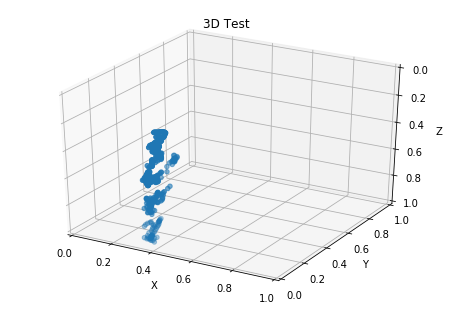

In [7]:
# visualization learned intense
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
# Attaching 3D axis to the figure
    
fn = 'sbu_cleaned/05/s01s02001.txt'
with open(fn,'r') as src_file:
    video = get_video(src_file)
    act_video, react_video = divide_video(video)        
    fig, ax = canvas()
    
    #ax.scatter(j1z,j1x,j1y)
    act_video = act_video.reshape((-1,3))
    print act_video.shape
    
    # draw_vector(ax,joints_react[0,:],joints_react[-2,:])    
    draw_points(ax, act_video)
    plt.show()


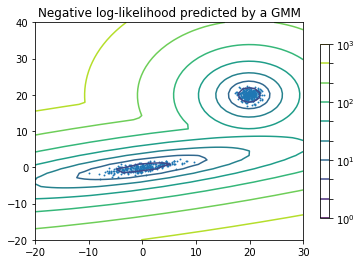

In [8]:
#GMM demo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()